<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuralDecoder/blob/main/BrainDecoder/Basics/plot_sleep_staging_eldele2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sleep staging on the Sleep Physionet dataset using Eldele2021

This tutorial shows how to train and test a sleep staging neural network with
Braindecode. We use the attention-based model from [1]_ with the time distributed approach of [2]_
to learn on sequences of EEG windows using the openly accessible Sleep Physionet dataset [3]_ [4]_.


In [1]:
!pip install braindecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.6 MB/s eta 0:00:00


## Loading and preprocessing the dataset

### Loading

First, we load the data using the
:class:`braindecode.datasets.sleep_physionet.SleepPhysionet` class. We load
two recordings from two different individuals: we will use the first one to
train our network and the second one to evaluate performance (as in the `MNE`_
sleep staging example).





In [2]:
from numbers import Integral
from braindecode.datasets import SleepPhysionet

subject_ids = [0, 1]
crop = (0, 30 * 400)  # we only keep 400 windows of 30s to speed example
dataset = SleepPhysionet(
    subject_ids=subject_ids, recording_ids=[2], crop_wake_mins=30,
    crop=crop)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


100%|█████████████████████████████████████| 51.6M/51.6M [00:00<00:00, 27.4GB/s]
100%|█████████████████████████████████████| 4.58k/4.58k [00:00<00:00, 1.12MB/s]
100%|█████████████████████████████████████| 52.0M/52.0M [00:00<00:00, 16.5GB/s]
100%|█████████████████████████████████████| 5.08k/5.08k [00:00<00:00, 2.47MB/s]

Download complete in 01m43s (98.8 MB)
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


### Preprocessing

Next, we preprocess the raw data. We convert the data to microvolts and apply
a lowpass filter.



In [3]:
from braindecode.preprocessing import preprocess, Preprocessor
from numpy import multiply

high_cut_hz = 30
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor(lambda data: multiply(data, factor), apply_on_array=True),  # Convert from V to uV
    Preprocessor('filter', l_freq=None, h_freq=high_cut_hz)
]

# Transform the data
preprocess(dataset, preprocessors)

Reading 0 ... 1200000  =      0.000 ... 12000.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)



/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Reading 0 ... 1200000  =      0.000 ... 12000.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)



### Extract windows

We extract 30-s windows to be used in the classification task.
The Eldele2021 model takes a single channel as input. Here, the Fpz-Cz channel is used as it
was found to give better performance than using the Pz-Oz channel



In [4]:
from braindecode.preprocessing import create_windows_from_events

mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

window_size_s = 30
sfreq = 100
window_size_samples = window_size_s * sfreq

windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples,
    picks="Fpz-Cz",  # the other option is Pz-Oz,
    preload=True,
    mapping=mapping
)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/windowers.py:130: UserWarning: Using reject or picks or flat or dropping bad windows means mne Epochs are created, which will be substantially slower and may be deprecated in the future.
  warnings.warn('Using reject or picks or flat or dropping bad windows means '


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


### Window preprocessing

We also preprocess the windows by applying channel-wise z-score normalization
in each window.



In [5]:
from sklearn.preprocessing import scale as standard_scale

preprocess(windows_dataset, [Preprocessor(standard_scale, channel_wise=True)])

### Split dataset into train and valid

We split the dataset into training and validation set taking
every other subject as train or valid.



In [6]:
split_ids = dict(train=subject_ids[::2], valid=subject_ids[1::2])
splits = windows_dataset.split(split_ids)
train_set, valid_set = splits["train"], splits["valid"]

## Create sequence samplers

Following the time distributed approach of [2]_, we need to provide our
neural network with sequences of windows, such that the embeddings of
multiple consecutive windows can be concatenated and provided to a final
classifier. We can achieve this by defining Sampler objects that return
sequences of window indices.
To simplify the example, we train the whole model end-to-end on sequences,
rather than using the two-step approach of [2]_ (i.e. training the feature
extractor on single windows, then freezing its weights and training the
classifier).




In [7]:
from braindecode.samplers import SequenceSampler

n_windows = 3  # Sequences of 3 consecutive windows
n_windows_stride = 3  # Maximally overlapping sequences

train_sampler = SequenceSampler(
    train_set.get_metadata(), n_windows, n_windows_stride, randomize=True
)
valid_sampler = SequenceSampler(valid_set.get_metadata(), n_windows, n_windows_stride)

# Print number of examples per class
print('Training examples: ', len(train_sampler))
print('Validation examples: ', len(valid_sampler))

Training examples:  133
Validation examples:  133


We also implement a transform to extract the label of the center window of a
sequence to use it as target.



In [8]:
import numpy as np


# Use label of center window in the sequence
def get_center_label(x):
    if isinstance(x, Integral):
        return x
    return x[np.ceil(len(x) / 2).astype(int)] if len(x) > 1 else x


train_set.target_transform = get_center_label
valid_set.target_transform = get_center_label

Finally, since some sleep stages appear a lot more often than others (e.g.
most of the night is spent in the N2 stage), the classes are imbalanced. To
avoid overfitting on the more frequent classes, we compute weights that we
will provide to the loss function when training.



In [9]:
from sklearn.utils import compute_class_weight

y_train = [train_set[idx][1] for idx in train_sampler]
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

## Create model

We can now create the deep learning model. In this tutorial, we use the sleep
staging architecture introduced in [1]_, which is an attention-based
neural network. We use the time distributed version of the model, where the
feature vectors of a sequence of windows are concatenated and passed to a
linear layer for classification.




In [10]:
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerEldele2021, TimeDistributed

cuda = torch.cuda.is_available()  # check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to reproduce results
set_random_seeds(seed=31, cuda=cuda)

n_classes = 5
# Extract number of channels and time steps from dataset
n_channels, input_size_samples = train_set[0][0].shape

feat_extractor = SleepStagerEldele2021(
    sfreq,
    n_outputs=n_classes,
    n_times=input_size_samples,
    return_feats=True,
)

model = nn.Sequential(
    TimeDistributed(feat_extractor),  # apply model on each 30-s window
    nn.Sequential(  # apply linear layer on concatenated feature vectors
        nn.Flatten(start_dim=1),
        nn.Dropout(0.5),
        nn.Linear(feat_extractor.len_last_layer * n_windows, n_classes)
    )
)

# Send model to GPU
if cuda:
    model.cuda()

## Training

We can now train our network. :class:`braindecode.EEGClassifier` is a
braindecode object that is responsible for managing the training of neural
networks. It inherits from :class:`skorch.NeuralNetClassifier`, so the
training logic is the same as in
[Skorch](https://skorch.readthedocs.io/en/stable/)_.




In [11]:
from skorch.helper import predefined_split
from skorch.callbacks import EpochScoring
from braindecode import EEGClassifier

lr = 1e-3
batch_size = 32
n_epochs = 3  # we use few epochs for speed and but more than one for plotting

train_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=True, name='train_bal_acc',
    lower_is_better=False)
valid_bal_acc = EpochScoring(
    scoring='balanced_accuracy', on_train=False, name='valid_bal_acc',
    lower_is_better=False)
callbacks = [
    ('train_bal_acc', train_bal_acc),
    ('valid_bal_acc', valid_bal_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    criterion__weight=torch.Tensor(class_weights).to(device),
    optimizer=torch.optim.Adam,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device,
    classes=np.unique(y_train)
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_bal_acc    train_loss    valid_acc    valid_bal_acc    valid_loss     dur
-------  ---------------  ------------  -----------  ---------------  ------------  ------
      1           0.1471        3.1803       0.3158           0.1706        3.4826  8.8400
      2           0.2712        1.8686       0.2030           0.2255        2.1791  13.2197
      3           0.4702        1.4849       0.2256           0.2200        4.2129  12.3060


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=Sequential(
    (0): TimeDistributed(
      (module): SleepStagerEldele2021(
        (feature_extractor): Sequential(
          (0): _MRCNN(
            (GELU): GELU(approximate='none')
            (features1): Sequential(
              (0): Conv1d(1, 64, kernel_size=(50,), stride=(6,), padding=(24,), bias=False)
              (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): GELU(approximate='none')
              (3): MaxPool1d(kernel_size=8, stride=2, padding=4, dilation=1, ceil_mode=False)
              (4): Dropout(p=0.5, inplace=False)
              (5): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
              (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (7): GELU(approximate='none')
              (8): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)

## Plot results

We use the history stored by Skorch during training to plot the performance of
the model throughout training. Specifically, we plot the loss and the balanced
balanced accuracy for the training and validation sets.



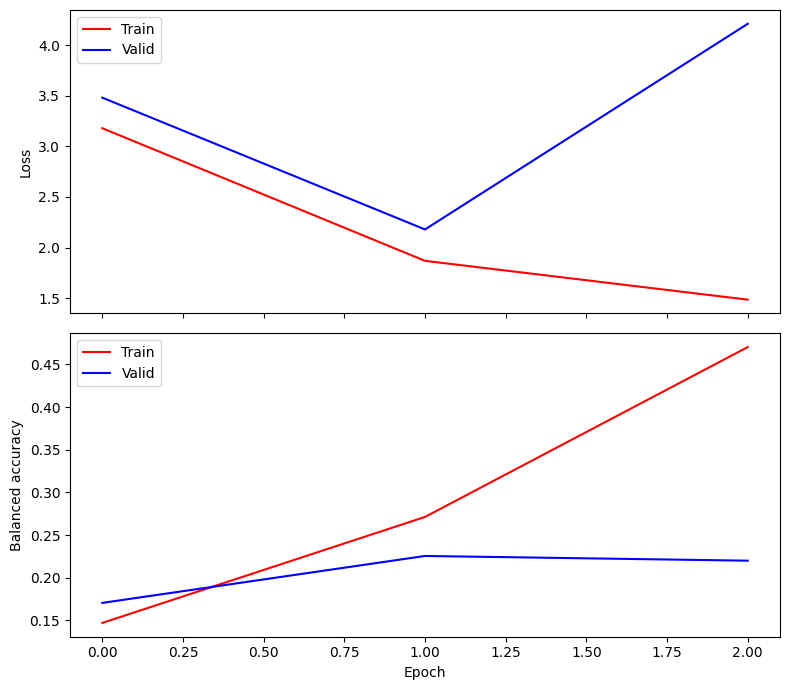

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())
df.index.name = "Epoch"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
df[['train_loss', 'valid_loss']].plot(color=['r', 'b'], ax=ax1)
df[['train_bal_acc', 'valid_bal_acc']].plot(color=['r', 'b'], ax=ax2)
ax1.set_ylabel('Loss')
ax2.set_ylabel('Balanced accuracy')
ax1.legend(['Train', 'Valid'])
ax2.legend(['Train', 'Valid'])
fig.tight_layout()
plt.show()

Finally, we also display the confusion matrix and classification report:




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

              precision    recall  f1-score   support

           0       1.00      0.02      0.03        60
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00        48
           3       0.15      1.00      0.26        19
           4       0.00      0.00      0.00         0

    accuracy                           0.15       133
   macro avg       0.23      0.20      0.06       133
weighted avg       0.47      0.15      0.05       133



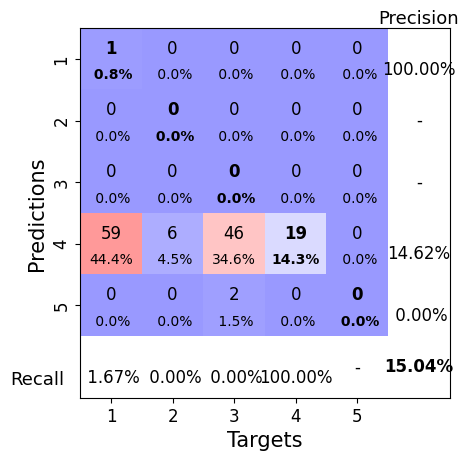

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
from braindecode.visualization import plot_confusion_matrix

y_true = [valid_set[[i]][1][0] for i in range(len(valid_sampler))]
y_pred = clf.predict(valid_set)

confusion_mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(confusion_mat=confusion_mat)
#                      class_names=['Wake', 'N1', 'N2', 'N3', 'N4', 'REM'])

print(classification_report(y_true, y_pred))

Finally, we can also visualize the hypnogram of the recording we used for
validation, with the predicted sleep stages overlaid on top of the true
sleep stages. We can see that the model cannot correctly identify the
different sleep stages with this amount of training.



Text(0, 0.5, 'Sleep stage')

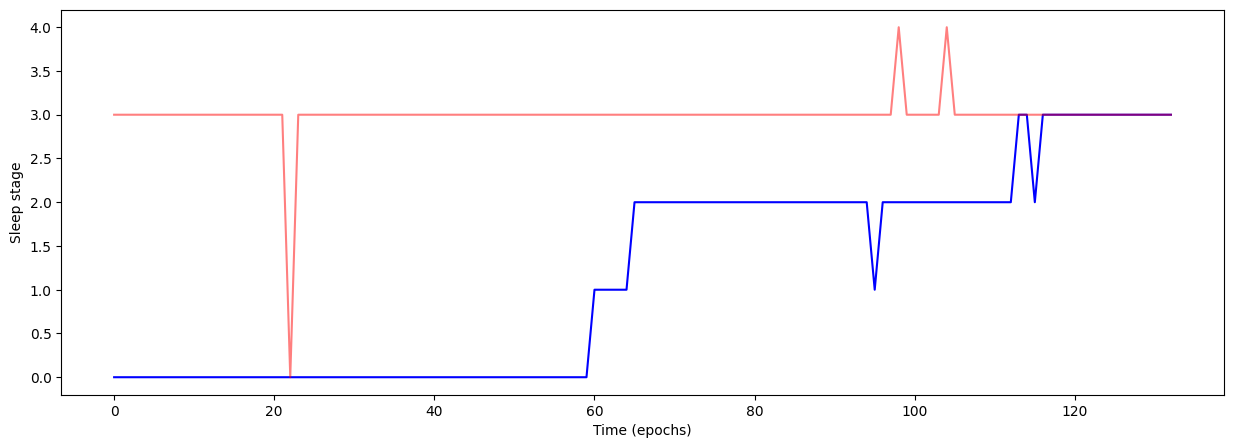

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_true, color='b', label='Expert annotations')
ax.plot(y_pred.flatten(), color='r', label='Predict annotations', alpha=0.5)
ax.set_xlabel('Time (epochs)')
ax.set_ylabel('Sleep stage')

The model was able to learn despite the low amount of data that was available
(only two recordings in this example) and reached a balanced accuracy of
about 43% in a 5-class classification task (chance-level = 20%) on held-out
data over 10 epochs.

<div class="alert alert-info"><h4>Note</h4><p>To further improve performance, the number of epochs should be increased.
   It has been reduced here for faster run-time in document generation. In
   testing, 10 epochs provided reasonable performance with around 89% balanced
   accuracy on training data and around 43% on held out validation data.
   Increasing the number of training recordings and optimizing the hyperparameters
   will also help increase performance</p></div>

